In [ ]:
!pip install rsatoolbox


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.0/656.0 kB 7.9 MB/s eta 0:00:00


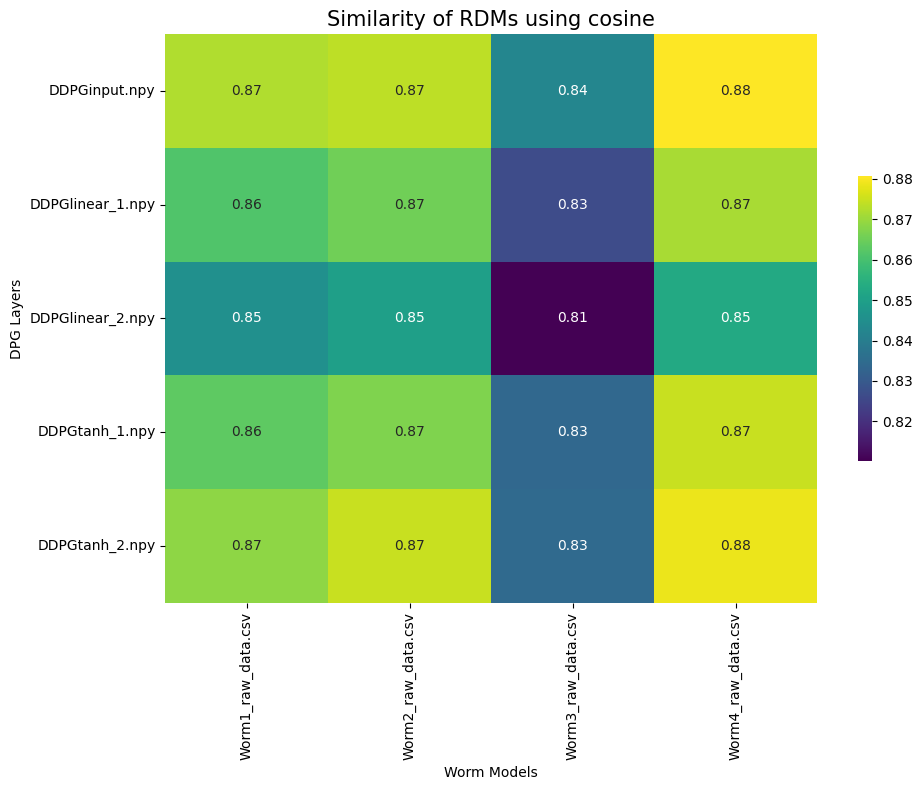

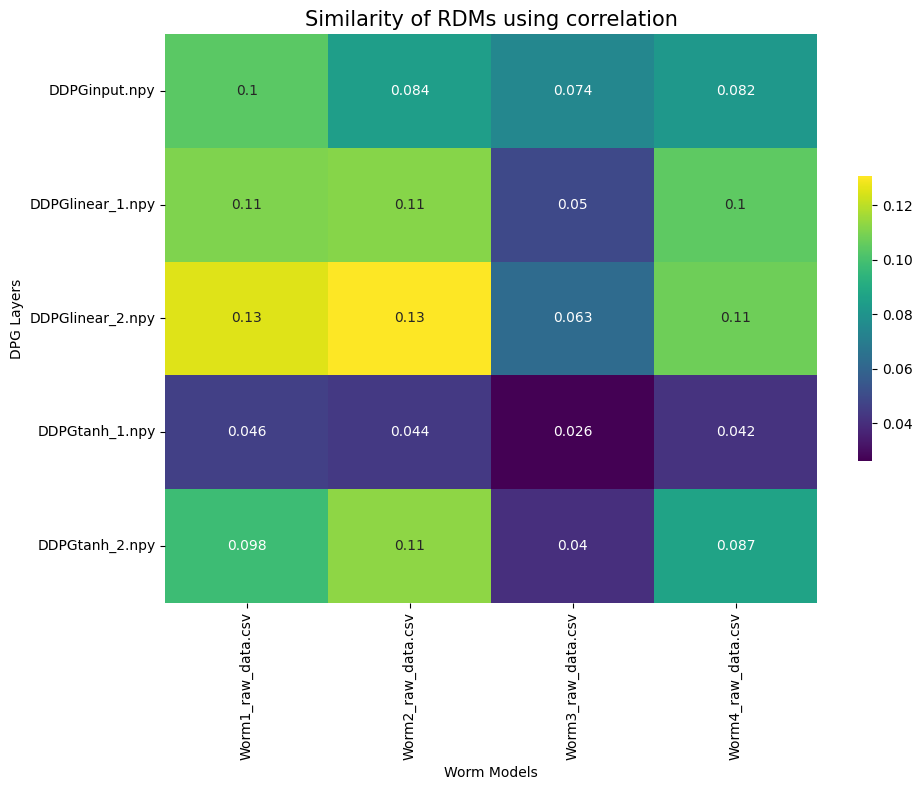

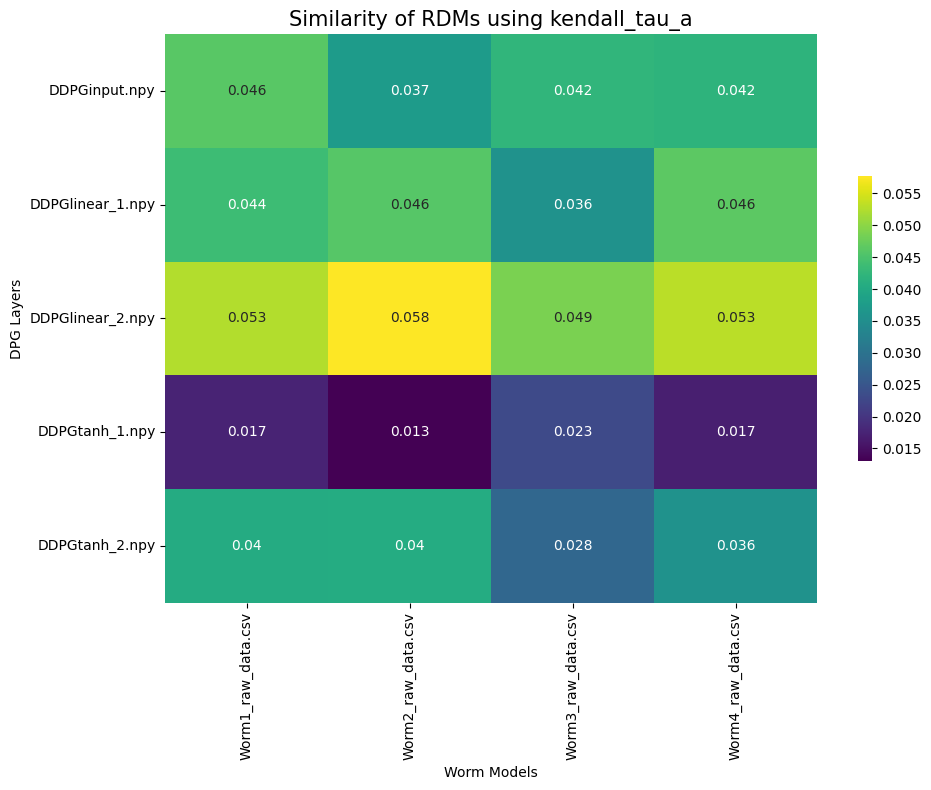

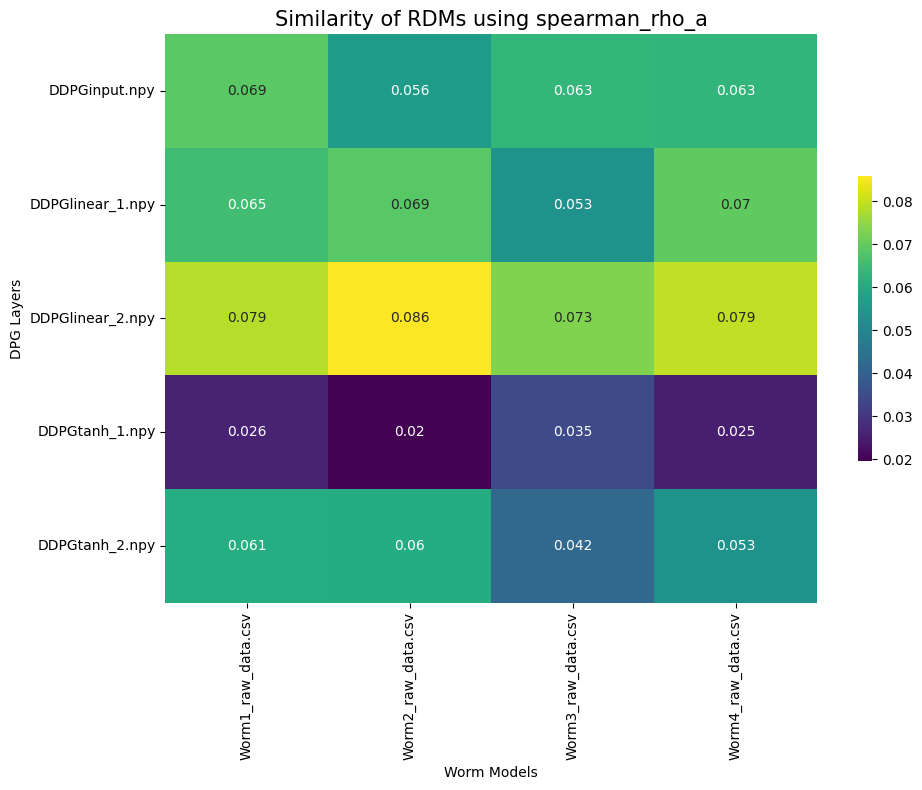


Results using cosine:
[[0.87223544 0.87359464 0.84264956 0.88062307]
 [0.86136311 0.86538443 0.82642794 0.8713678 ]
 [0.84539034 0.84982389 0.8103141  0.85266348]
 [0.86314582 0.8671216  0.83371058 0.87461084]
 [0.86872846 0.87483989 0.83421228 0.87853535]]

Results using correlation:
[[0.10395506 0.08448119 0.07446778 0.08181729]
 [0.11064256 0.11154278 0.04952299 0.1049038 ]
 [0.12573946 0.13063659 0.06257407 0.10757853]
 [0.04606789 0.0436181  0.02637059 0.0416514 ]
 [0.09795084 0.11274344 0.04039394 0.08698437]]

Results using kendall_tau_a:
[[0.04607912 0.03734786 0.04219764 0.04198317]
 [0.04370286 0.04593878 0.03557302 0.04648111]
 [0.05254521 0.05766994 0.04862507 0.05311726]
 [0.01737372 0.01309372 0.02319133 0.01680427]
 [0.04041476 0.04048388 0.02783105 0.03568601]]

Results using spearman_rho_a:
[[0.06899033 0.05604386 0.0630683  0.06300671]
 [0.06545098 0.06874679 0.05325259 0.06953093]
 [0.07855244 0.08580005 0.07311374 0.07947075]
 [0.02598257 0.01966778 0.03456778 0.02

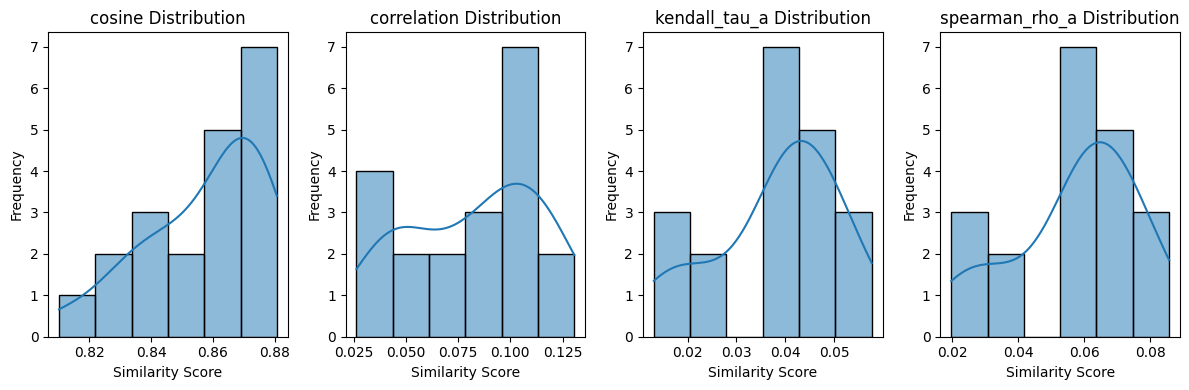

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy import stats

# Load DPG activation data
base_path = '/content/'
dpg_files = [
    'DDPGinput.npy',
    'DDPGlinear_1.npy',
    'DDPGlinear_2.npy',
    'DDPGtanh_1.npy',
    'DDPGtanh_2.npy'
]

# Read the activation data into a dictionary
dpg_data = {file: np.load(base_path + file) for file in dpg_files}

# Load worm data
worm_files = [
    'Worm1_raw_data.csv',
    'Worm2_raw_data.csv',
    'Worm3_raw_data.csv',
    'Worm4_raw_data.csv'
]

# Read the worm data into a dictionary
worm_data = {file: pd.read_csv(base_path + file).values for file in worm_files}

# Function to compute the RDM
def compute_rdm(activations):
    dissimilarities = pdist(activations, metric='euclidean')
    rdm = squareform(dissimilarities)
    return rdm

# Function to sample data to a specific size
def sample_data(data, target_size):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    elif len(data.shape) > 2:
        data = data.reshape(data.shape[0], -1)

    if data.shape[0] > target_size:
        indices = np.sort(np.random.choice(data.shape[0], target_size, replace=False))
        return data[indices]
    else:
        return data

# Find the smallest dataset size
min_size = min(min(data.shape[0] for data in dpg_data.values()),
               min(data.shape[0] for data in worm_data.values()))

# Use a smaller size for RDM computation to keep memory usage manageable
rdm_size = min(min_size, 1000)  # Adjust this value as needed

# Sample and compute RDMs for each dataset
dpg_rdms = {}
for file, data in dpg_data.items():
    try:
        sampled_data = sample_data(data, rdm_size)
        dpg_rdms[file] = compute_rdm(sampled_data)
    except ValueError as e:
        print(f"Error processing {file}: {e}")
        print(f"Data shape: {data.shape}")
        print(f"Sampled data shape: {sampled_data.shape}")

worm_rdms = {}
for file, data in worm_data.items():
    try:
        sampled_data = sample_data(data, rdm_size)
        worm_rdms[file] = compute_rdm(sampled_data)
    except ValueError as e:
        print(f"Error processing {file}: {e}")
        print(f"Data shape: {data.shape}")
        print(f"Sampled data shape: {sampled_data.shape}")

# Functions to compute similarity between two RDMs
def cosine_similarity(rdm1, rdm2):
    v1 = rdm1[np.triu_indices(rdm1.shape[0], k=1)]
    v2 = rdm2[np.triu_indices(rdm2.shape[0], k=1)]
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def correlation_similarity(rdm1, rdm2):
    v1 = rdm1[np.triu_indices(rdm1.shape[0], k=1)]
    v2 = rdm2[np.triu_indices(rdm2.shape[0], k=1)]
    return np.corrcoef(v1, v2)[0, 1]

def kendall_tau_a(rdm1, rdm2):
    v1 = rdm1[np.triu_indices(rdm1.shape[0], k=1)]
    v2 = rdm2[np.triu_indices(rdm2.shape[0], k=1)]
    tau, _ = stats.kendalltau(v1, v2, variant='c')
    return tau

def spearman_rho_a(rdm1, rdm2):
    v1 = rdm1[np.triu_indices(rdm1.shape[0], k=1)]
    v2 = rdm2[np.triu_indices(rdm2.shape[0], k=1)]
    rho, _ = stats.spearmanr(v1, v2)
    return rho

# Compute similarities
methods = ['cosine', 'correlation', 'kendall_tau_a', 'spearman_rho_a']
similarity_functions = {
    'cosine': cosine_similarity,
    'correlation': correlation_similarity,
    'kendall_tau_a': kendall_tau_a,
    'spearman_rho_a': spearman_rho_a
}

similarities = {method: np.zeros((len(dpg_rdms), len(worm_rdms))) for method in methods}

for method in methods:
    for i, (dpg_layer, dpg_rdm) in enumerate(dpg_rdms.items()):
        for j, (worm_file, worm_rdm) in enumerate(worm_rdms.items()):
            similarities[method][i, j] = similarity_functions[method](dpg_rdm, worm_rdm)

# Visualization of the comparisons
def plot_comparison_results(similarities, method):
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarities[method], annot=True, cmap='viridis', cbar_kws={'shrink': .5})
    plt.title(f'Similarity of RDMs using {method}', fontsize=15)
    plt.xlabel('Worm Models')
    plt.ylabel('DPG Layers')
    plt.xticks(np.arange(len(worm_rdms)) + 0.5, worm_rdms.keys(), rotation=90)
    plt.yticks(np.arange(len(dpg_rdms)) + 0.5, dpg_rdms.keys(), rotation=0)
    plt.tight_layout()
    plt.show()

# Plot the comparison results
for method in methods:
    plot_comparison_results(similarities, method)

# Print the comparison results
for method, result in similarities.items():
    print(f'\nResults using {method}:')
    print(result)

# Visualize the distribution of similarity scores
plt.figure(figsize=(12, 4))
for i, (method, result) in enumerate(similarities.items()):
    plt.subplot(1, 4, i+1)
    sns.histplot(result.flatten(), kde=True)
    plt.title(f'{method} Distribution')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()